In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

data_folder = './data/'
data=pd.read_csv(data_folder + 'marketing_campaign.csv',header=0,sep=';', index_col = 'ID')

In [2]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21/8/2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19/1/2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


In [3]:
data.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [4]:
#Spending variable creation
data['Age']=2021-data['Year_Birth']

data['Spending']=data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']

#Seniority variable creation
last_date = date(2021, 12, 13)
print(last_date)

2021-12-13


In [5]:
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%d/%m/%Y')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30
data=data.rename(columns={'NumWebPurchases': "Web_Purchases",'NumCatalogPurchases':'Catalog_Purchases','NumStorePurchases':'Store_Purchases', 
                          'NumWebVisitsMonth':'Web_Visits_Month'})

data['Children']=data['Kidhome']+data['Teenhome']
data['Has_Child'] = np.where(data.Children> 0, 1, 0)

data=data.rename(columns={'MntWines': "Wines",'MntFruits':'Fruits','MntMeatProducts':'Meat','MntFishProducts':'Fish','MntSweetProducts':'Sweets','MntGoldProds':'Gold',})

data=data[['Age','Education','Marital_Status','Income','Spending','Seniority','Has_Child','Wines','Fruits','Meat','Fish','Sweets','Gold','Web_Purchases','Catalog_Purchases','Store_Purchases','Web_Visits_Month']]
data.head()

,Age,Education,Marital_Status,Income,Spending,Seniority,Has_Child,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,112.900000,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,94.566667,1,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,101.200000,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,95.433333,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,96.166667,1,173,43,118,46,27,15,5,3,6,5


In [6]:
my_max = data['Income'].loc[data['Income'].idxmax()]      # Maximum in column
print(my_max)
my_min = data['Income'].loc[data['Income'].idxmin()]      # Minimum in column
print(my_min)

666666.0
1730.0


<AxesSubplot:>

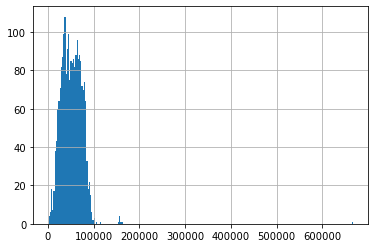

In [7]:
data['Income'].hist(bins=250)

In [8]:
print('Antes con los valores nulos',len(data[data.isna().any(axis=1)]))
print(data.mean().mean())

Antes con los valores nulos 24
3575.479786681279


In [9]:
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace=True)
data['Income']

ID
5524     58138.0
2174     46344.0
4141     71613.0
6182     26646.0
5324     58293.0
          ...   
10870    61223.0
4001     64014.0
7270     56981.0
8235     69245.0
9405     52869.0
Name: Income, Length: 2240, dtype: float64

In [10]:
print('despues sin valores nulos',len(data[data.isna().any(axis=1)]))

despues sin valores nulos 0


In [11]:
data = data[data['Income']<600000]

In [12]:
data

,Age,Education,Marital_Status,Income,Spending,Seniority,Has_Child,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,112.900000,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,94.566667,1,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,101.200000,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,95.433333,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,96.166667,1,173,43,118,46,27,15,5,3,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,54,Graduation,Married,61223.0,1341,103.500000,1,709,43,182,42,118,247,9,3,4,5
4001,75,PhD,Together,64014.0,444,91.433333,1,406,0,30,0,0,8,8,2,5,7
7270,40,Graduation,Divorced,56981.0,1241,95.966667,0,908,48,217,32,12,24,2,3,13,6


<AxesSubplot:>

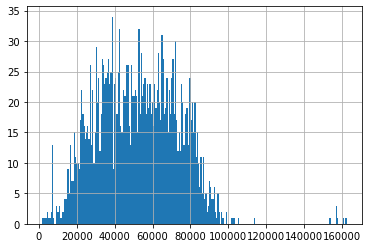

In [13]:
data['Income'].hist(bins=250)

In [14]:
# Adding labels to DataFrame
data['Total_Spent_Food'] = data['Wines'] + data['Fruits'] + data['Meat'] + data['Fish'] + data['Sweets']
data['Spent_More_In_Food_Than_Gold'] = np.where(data['Total_Spent_Food'] > data['Gold'], 1, 0)

data['Spent_More_In_Wines_Than_Meat'] = np.where(data['Wines'] > data['Meat'], 1, 0)
data

,Age,Education,Marital_Status,Income,Spending,Seniority,Has_Child,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month,Total_Spent_Food,Spent_More_In_Food_Than_Gold,Spent_More_In_Wines_Than_Meat
ID,,,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,112.900000,0,635,88,546,172,88,88,8,10,4,7,1529,1,1
2174,67,Graduation,Single,46344.0,27,94.566667,1,11,1,6,2,1,6,1,1,2,5,21,1,1
4141,56,Graduation,Together,71613.0,776,101.200000,0,426,49,127,111,21,42,8,2,10,4,734,1,1
6182,37,Graduation,Together,26646.0,53,95.433333,1,11,4,20,10,3,5,2,0,4,6,48,1,0
5324,40,PhD,Married,58293.0,422,96.166667,1,173,43,118,46,27,15,5,3,6,5,407,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,54,Graduation,Married,61223.0,1341,103.500000,1,709,43,182,42,118,247,9,3,4,5,1094,1,1
4001,75,PhD,Together,64014.0,444,91.433333,1,406,0,30,0,0,8,8,2,5,7,436,1,1
7270,40,Graduation,Divorced,56981.0,1241,95.966667,0,908,48,217,32,12,24,2,3,13,6,1217,1,1
